In [1]:
#################################### IMPORTS ###################################################
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import tensorflow as tf
import datetime
from keras.backend.tensorflow_backend import set_session

Using TensorFlow backend.


In [2]:
##################### INICIALIZACAO DE VARIAVEIS ################################################
index_arquivo = ['preco']#, 'hr_int', 'preco_pon', 'qnt_soma', 'max', 'min', 'IND', 'ISP'] #index do arquivo
steps = [] # 9h04 -> 17h50 a cada 5 segundos 
epocas = 1000 #quantidade de vezes que vai rodar todos os dias
janela = 10 #janela de valores
n_variaveis = len(index_arquivo) #'preco', 'hr_int', 'preco_pon', 'qnt_soma', 'max', 'min', 'IND', 'ISP'
n_entradas = n_variaveis * janela + 3 #ncont, valor, posicao e inputs
n_neuronios = 216 #numero de neuronios da camada escondida
n_saidas = 3 #nmero de saidas da rede (compra, vende, segura)
custo = 1.06/2 #custo da operao
melhor_reward = 0
lim_cont = 10
posicao_max = 100*lim_cont #define variavel para normalizar a posicao

versao_arquivo = 2

carregar_pesos = False
carregar_epoca_epsilon = False
epoca_init = 0
if carregar_epoca_epsilon:
    file = open("./epoca_epsilon.txt", "r")
    valores = file.read().split(',')
    epoca_init = int(valores[0])
    epsilon = float(valores[1])
    file.close()
else:
    epsilon = 1. #valor de epsilon
epsilon_min = 0.01 #valor minimo de epsilon
epsilon_decay = (epsilon - epsilon_min) / (epocas - epoca_init) #o valor que vai retirado do epsilon por epoca

rewards = [0] #variavel para guardar rewards
plotx = [0] #variavel para guardar valores a serem plotados do eixo x

In [3]:
####################### LEITURA DOS DADOS #######################################################
caminho_arquivo = ('./consolidado.csv')
arquivo = pd.read_csv(caminho_arquivo) #le arquivo
inputs = arquivo[index_arquivo]
if versao_arquivo == 1: #se quiser usar apenas os dias com IND e ISP
    inputs = inputs[inputs['IND'] != 0]
    arquivo = arquivo[arquivo['IND'] != 0]
pmax = np.amax( inputs.loc[:, inputs.columns[0]] ) #define valor minimo do preo
pmin = np.amin( inputs.loc[:, inputs.columns[0]] ) #define valor maximo do preo

for i in range( inputs.shape[1] ): #roda normalizo para todas as colunas
    imax = np.amax( inputs.loc[:, inputs.columns[i]] ) #pega valor maximo
    imin = np.amin( inputs.loc[:, inputs.columns[i]] ) #pega valor minimo
    inputs.loc[:, inputs.columns[i]] = ( inputs.loc[:, inputs.columns[i]] - imin ) / ( imax - imin ) #normaliza prs

dt = arquivo['dt'].values #cria coluna apenas dos dias

steps = []
ultimo_dia = 0
dias_para_rodar = [] #variavel para colocar os dias a serem rodados
j = 0
hr = []
h = 0
n_steps = 106 #especifico pra 5min
for i in range( 0, len(dt) ):    
    if (dt[i] != ultimo_dia):
        steps.append(i) #numero de linhas entre dias
        ultimo_dia = dt[i]
        dias_para_rodar.append(j) #numero do dia
        j += 1
        h = 0
    hr.append(h)
    h += 1
step_max = 105
#hr = hr/step_max
#inputs['hr_int'] = hr


dias = len(steps)
dias = 220

D:\anaconda\lib\site-packages\pandas\core\indexing.py:635: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item_labels[indexer[info_axis]]] = value


In [4]:
########################################   BIBLIOTECAS ####################################
import random
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras import backend as K            #importa backend para clear_session()

##################### MODELO DQN ####################################################
class DQNAgent:
    ########################### INICIALIZA ###########################################
    def __init__(self, state_size, action_size, epsilon, janela, n_neuronios, n_variaveis):
        self.state_size = state_size
        self.n_neuronios = n_neuronios
        self.action_size = action_size
        self.janela = janela
        self.n_variaveis = n_variaveis
        self.limpa_memoria()
        self.gamma = 0.97       # discount rate
        self.epsilon = epsilon  # exploration rate
        self.learning_rate = 1e-7
        self.model = self.cria_modelo()
        self.model.summary()
        self.state = []
        self.next_state = []

################################# REDE NEURAL ###########################################
    def cria_modelo(self):
        # Neural Net for Deep-Q learning Model
        model = Sequential()
        """
        model.add(Dense(self.n_neuronios, input_dim=self.state_size, activation='relu')) #camada de entrada (escondida)
        model.add(Dense(self.n_neuronios, activation='relu')) #camada escondida
        model.add(Dense(self.n_neuronios, activation='relu')) #camada escondida
        model.add(Dense(self.action_size, activation='softmax')) #camada de saida
        model.compile(loss='categorical_crossentropy', optimizer=tf.train.AdamOptimizer(learning_rate=self.learning_rate)) #compilador
        """
        
        model.add(Dense(256, input_dim=self.state_size, activation='relu')) #camada de entrada (escondida)
        model.add(Dense(192, activation='relu')) #camada escondida
        model.add(Dense(128, activation='relu')) #camada escondida
        model.add(Dense(self.action_size, activation='linear')) #camada de saida
        model.compile(loss='mse', optimizer=tf.train.AdamOptimizer(learning_rate=self.learning_rate)) #compilador
        
        return model

    def limpa_memoria(self):
        self.state = np.empty((0,))
        self.next_state = np.empty((0,))
        self.memory = []
        
    def toma_acao(self, valores_ant, teste):
        if not teste and np.random.rand() <= self.epsilon: #se o numero aleatorio for menor que o epsilon
            return random.randrange(self.action_size) #retorna acao aleatoria
        estado = np.array([np.append(self.state, valores_ant)]) #cria valor de agora        
        act_values = self.model.predict(estado, batch_size=1) #calcula qual a melhor acao
        return np.argmax(act_values[0])  # returns action
    
    def treina_modelo(self, batch_size=step_max):
        x = np.zeros((batch_size+1, self.state_size))
        y = np.zeros((batch_size+1, self.action_size))
        i = 0
        for acao, reward, estado, prox_estado, done in self.memory:        
            
            target = reward
            if not done:
                target = (reward + self.gamma * np.amax(self.model.predict(prox_estado, batch_size=batch_size)[0])) #pega valor que quer chegar

            target_f = self.model.predict(estado, batch_size=batch_size) #pega valor que chegou
            target_f[0][acao] = target #define o valor que deseja chegar
            x[i,:] = estado
            y[i,:] = target_f
            i = i + 1
            
        self.model.fit(x, y, epochs=1, verbose=0, batch_size=batch_size) #treina modelo
        
    def tira_ultimo_state(self):
        if self.state.shape[0] > self.janela * self.n_variaveis:
            self.state = self.state[self.n_variaveis:] #tira os ultimos preos
        if self.next_state.shape[0] > self.janela * self.n_variaveis:
            self.next_state = self.next_state[self.n_variaveis:] #tira os ultimos preos
    
    def remember(self, acao, reward, valores_ant, valores_dps, done):
        prox_estado = np.array([np.append(self.next_state, valores_dps)]) #cria proximo estado
        estado = np.array([np.append(self.state, valores_ant)]) #cria valor de agora
        self.memory.append((acao, reward, estado, prox_estado, done))
    
    def carrega_pesos(self, name):
        self.model.load_weights(name) #carrega pesos

    def salva_pesos(self, name):
        self.model.save_weights(name) #salva pesos
                
########################  DECLARA MODELO ################################
modelo = DQNAgent(n_entradas, n_saidas, epsilon, janela, n_neuronios, n_variaveis)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 256)               3584      
_________________________________________________________________
dense_2 (Dense)              (None, 192)               49344     
_________________________________________________________________
dense_3 (Dense)              (None, 128)               24704     
_________________________________________________________________
dense_4 (Dense)              (None, 3)                 387       
Total params: 78,019
Trainable params: 78,019
Non-trainable params: 0
_________________________________________________________________


In [5]:
########################### FUNCOES ###############################################################

def atuacao( preco, ncont, acao, custo, valor ):  #preo atual, n de contratos posicionados,
                                                #acaoo atual, custo, valor da posio
    preco_cheio = 0.
    valor_cheio = 0.
    ncont_anterior = ncont #salva posio anterior
    ncont += acao #posio atual = pos anterior + ao
    r = 0.
        
    if acao != 0:
        if (acao*ncont_anterior) < 0:    #realizacao (lucro ou prejuizo)
            valor_cheio = ( valor * ( pmax - pmin ) + pmin )  #valores nao normalizados
            preco_cheio = ( preco * ( pmax - pmin ) + pmin )
            r = acao*(valor_cheio - preco_cheio)*10 - custo*abs(acao)  #reward se houve diminuicao da posicao
        else:
            r = -custo*abs(acao)                                       #reward = -custo*acao se houve operacao
        
        if valor!=0: 
            valor_cheio = ( valor * ( pmax - pmin ) + pmin )  #valores nao normalizados
        if abs(ncont) > 0:
            valor = (ncont_anterior*valor + acao*preco)/ncont     
        else:
            valor = 0
            
    if valor!=0: valor_cheio = ( valor * ( pmax - pmin ) + pmin )  #valor posicionado atual
            
    dp = ( preco * ( pmax - pmin ) + pmin ) - valor_cheio #variacao do preco atual e do preco de compra/venda
    posicao = ncont * dp * 10 - custo*abs(ncont)           #posicao = lucro (INSTANTNEO)
    
    return ncont, valor, posicao, ncont_anterior, r

def obter_acao(ncont, valores_ant):
    decisao = modelo.toma_acao(valores_ant, False) #calcula a saida da rede neural
    
    if decisao == 0: #comprar
        if ncont < lim_cont: #s compra se no tem nada ainda
            return 1
    elif decisao == 1: #vender
        if ncont > -lim_cont: #só vende se tiver alguma coisa
            return -1
    return 0 #neutro

def rodar_1dia(precos, custo, dia):
    global melhor_reward
    ncont = 0 #cria variavel de quantidade de contratos
    ncont_anterior = 0 #cria variavel para quantidade de contratos anterior
    valor = 0 #cria variavel para preo medio
    reward = 0 #cria variavel para recompensa
    posicao = 0 #cria variavel de posio 
    erro = []
    modelo.limpa_memoria() #limpa o vetor de memoria
    done = False
    modelo.state = np.zeros(n_variaveis*janela)
    modelo.next_state = np.zeros(n_variaveis*janela)
    
    for step in range( steps[dia - 1], steps[dia] ):  #roda os dados
        
        ultimos_precos = precos[ step : step + 1 ] #pega os valores de agora
        modelo.state = np.append( modelo.state, ultimos_precos ) #adiciona na variavel de estado
        
        modelo.tira_ultimo_state()
        valores_ant = [ncont / lim_cont, valor, posicao/posicao_max] #grava os valores de antes - estado

        acao = obter_acao( ncont, valores_ant ) #obtem acao
        ncont, valor, posicao, ncont_anterior, r = atuacao(precos['preco'][step], ncont, acao, custo, valor)
        reward += r
        #print (hr[step]*step_max, acao)
        #print("acao: {0} reward: {1} step: {2}".format(acao, reward, hr[step]*step_max))
            
        prox_precos = precos[ step + 1 : step + 2 ] #pega os proximos valores
        modelo.next_state = np.append(modelo.next_state, prox_precos) #adiciona variavel na variavel de proximo estado
        modelo.tira_ultimo_state()
        valores_dps = [ncont / lim_cont, valor, posicao/posicao_max] #grava os valores de depois
        
        if step == (steps[dia] - 1):
            done = True
        else:
            modelo.remember(acao, reward, valores_ant, valores_dps, done)  #salva step na memoria
    
    reward += posicao #soma reward - DAY-TRADE (obs: custo nao havia sido considerado no reward pq acao era 0)
    
    modelo.remember(acao, reward, valores_ant, valores_dps, done)  #salva step na memoria
    
    modelo.treina_modelo() #roda o modelo com toda a memoria do dia
           
    if reward > melhor_reward:
        melhor_reward = reward
    return reward #retorna o valor do reward

dias_pos = 0
dias_neg = 0

def rodar_dias(precos, custo):   
    global dias_pos
    global dias_neg
    sum_rewards = 0 #cria variavel de somatoria de recompensas
    for dia in range( 1, dias ): #loop de dias
        reward = rodar_1dia(precos, custo, dia)
        sum_rewards += reward #roda 1 dia e adiciona o total na variavel de somatoria
        #print("dia {0} de {1}: R$ {2:0.2f}".format(dia, dias, reward)) #mostra o resultado do dia
        if reward>0: 
            dias_pos += 1
        elif reward<0:
            dias_neg += 1
    return sum_rewards


W1020 21:17:55.102722 10036 deprecation_wrapper.py:119] From D:\anaconda\lib\site-packages\keras\backend\tensorflow_backend.py:422: The name tf.global_variables is deprecated. Please use tf.compat.v1.global_variables instead.

W1020 21:17:55.644753 10036 deprecation_wrapper.py:119] From D:\anaconda\lib\site-packages\keras\backend\tensorflow_backend.py:431: The name tf.is_variable_initialized is deprecated. Please use tf.compat.v1.is_variable_initialized instead.

W1020 21:17:55.667755 10036 deprecation_wrapper.py:119] From D:\anaconda\lib\site-packages\keras\backend\tensorflow_backend.py:438: The name tf.variables_initializer is deprecated. Please use tf.compat.v1.variables_initializer instead.



resultado da epoca 0 = -151439.59
101
118
resultado da epoca 1 = -16459.31
108
111
resultado da epoca 2 = 8837.91
102
117
resultado da epoca 3 = -49601.94
106
113
resultado da epoca 4 = 27442.56
117
102
resultado da epoca 5 = -66360.65
101
118
resultado da epoca 6 = -109322.30
109
110
resultado da epoca 7 = -78408.07
110
109
resultado da epoca 8 = 26865.63
108
111
resultado da epoca 9 = -65996.24
111
108
resultado da epoca 10 = -144639.17
103
116
resultado da epoca 11 = 48749.70
105
114
resultado da epoca 12 = -106768.92
101
118
resultado da epoca 13 = -111905.49
96
123
resultado da epoca 14 = -46158.07
110
109
resultado da epoca 15 = 18448.91
105
114
resultado da epoca 16 = 64280.05
113
106
resultado da epoca 17 = 163209.69
122
97
resultado da epoca 18 = 95354.30
111
108
resultado da epoca 19 = -40517.63
112
107
resultado da epoca 20 = -82257.67
112
107
resultado da epoca 21 = 30807.29
110
109
resultado da epoca 22 = 133810.58
116
103
resultado da epoca 23 = 16773.38
104
115
resultado

resultado da epoca 196 = 167275.47
113
106
resultado da epoca 197 = 166828.00
116
103
resultado da epoca 198 = 45667.67
107
112
resultado da epoca 199 = 94979.66
121
98
resultado da epoca 200 = 129512.64
106
113
resultado da epoca 201 = 174873.46
108
111
resultado da epoca 202 = 33776.82
106
113
resultado da epoca 203 = 140843.96
112
107
resultado da epoca 204 = 100998.38
107
112
resultado da epoca 205 = 140961.65
104
115
resultado da epoca 206 = 128997.85
110
109
resultado da epoca 207 = 133755.59
110
109
resultado da epoca 208 = 64855.29
108
111
resultado da epoca 209 = 121382.71
111
108
resultado da epoca 210 = 9923.07
103
116
resultado da epoca 211 = 140374.28
111
108
resultado da epoca 212 = 197770.80
109
110
resultado da epoca 213 = 126140.73
112
107
resultado da epoca 214 = 180478.39
119
100
resultado da epoca 215 = 139238.02
109
110
resultado da epoca 216 = 8673.54
106
113
resultado da epoca 217 = 51001.55
103
116
resultado da epoca 218 = 158025.87
106
113
resultado da epoca 21

resultado da epoca 388 = 148883.01
120
99
resultado da epoca 389 = 137893.55
120
99
resultado da epoca 390 = 174992.33
122
97
resultado da epoca 391 = 157517.56
123
96
resultado da epoca 392 = 264066.29
128
91
resultado da epoca 393 = 153370.78
122
97
resultado da epoca 394 = 173034.93
118
101
resultado da epoca 395 = 136869.43
114
105
resultado da epoca 396 = 108865.95
124
95
resultado da epoca 397 = 101832.72
122
97
resultado da epoca 398 = 174246.85
130
89
resultado da epoca 399 = 219.78
119
100
resultado da epoca 400 = 130844.66
135
84
resultado da epoca 401 = 214506.85
129
90
resultado da epoca 402 = 115271.42
131
88
resultado da epoca 403 = 117316.88
125
94
resultado da epoca 404 = 146912.20
136
83
resultado da epoca 405 = 63712.87
125
94
resultado da epoca 406 = 76916.56
129
90
resultado da epoca 407 = 137729.55
132
87
resultado da epoca 408 = 74886.11
125
94
resultado da epoca 409 = 165541.57
133
86
resultado da epoca 410 = 163680.63
136
83
resultado da epoca 411 = 69006.24
118

resultado da epoca 582 = -29592.37
108
111
resultado da epoca 583 = 667.58
113
106
resultado da epoca 584 = -78395.93
103
116
resultado da epoca 585 = -342.54
108
111
resultado da epoca 586 = -21647.09
102
117
resultado da epoca 587 = -32398.23
104
115
resultado da epoca 588 = -29573.94
96
123
resultado da epoca 589 = -40854.32
102
117
resultado da epoca 590 = -61907.90
102
117
resultado da epoca 591 = -19776.35
107
112
resultado da epoca 592 = 10287.75
101
118
resultado da epoca 593 = -132126.44
90
129
resultado da epoca 594 = -10998.89
100
119
resultado da epoca 595 = 66412.14
109
110
resultado da epoca 596 = -44277.42
100
119
resultado da epoca 597 = -16062.29
96
123
resultado da epoca 598 = -100695.92
101
118
resultado da epoca 599 = -97129.90
98
121
resultado da epoca 600 = 36321.20
118
101
resultado da epoca 601 = -26139.81
102
117
resultado da epoca 602 = -59192.14
106
113
resultado da epoca 603 = -137342.55
92
127
resultado da epoca 604 = -24988.52
96
123
resultado da epoca 605

resultado da epoca 774 = -56787.10
103
116
resultado da epoca 775 = -66115.00
95
124
resultado da epoca 776 = -71668.73
104
115
resultado da epoca 777 = -139545.91
93
126
resultado da epoca 778 = -53344.51
101
118
resultado da epoca 779 = -134175.10
91
128
resultado da epoca 780 = -94046.75
89
130
resultado da epoca 781 = -130232.20
93
126
resultado da epoca 782 = -193923.29
89
130
resultado da epoca 783 = -126344.28
91
128
resultado da epoca 784 = -95681.39
94
125
resultado da epoca 785 = -107485.04
99
120
resultado da epoca 786 = -168592.89
87
132
resultado da epoca 787 = -164067.14
86
133
resultado da epoca 788 = -100380.54
99
120
resultado da epoca 789 = -130202.34
90
129
resultado da epoca 790 = -165012.73
96
123
resultado da epoca 791 = -177207.25
83
136
resultado da epoca 792 = -24577.32
100
119
resultado da epoca 793 = -174729.49
89
130
resultado da epoca 794 = -106619.68
100
119
resultado da epoca 795 = -110146.16
98
121
resultado da epoca 796 = -152059.36
90
129
resultado da 

resultado da epoca 965 = -209903.84
86
133
resultado da epoca 966 = -204238.28
86
133
resultado da epoca 967 = -195792.72
83
136
resultado da epoca 968 = -155520.81
88
131
resultado da epoca 969 = -198365.90
85
134
resultado da epoca 970 = -192121.11
89
130
resultado da epoca 971 = -195807.55
86
133
resultado da epoca 972 = -172053.07
85
134
resultado da epoca 973 = -200860.24
84
135
resultado da epoca 974 = -172258.92
89
130
resultado da epoca 975 = -187750.78
90
129
resultado da epoca 976 = -147353.16
95
124
resultado da epoca 977 = -155588.38
90
129
resultado da epoca 978 = -147101.82
92
127
resultado da epoca 979 = -162376.66
86
133
resultado da epoca 980 = -195805.02
89
130
resultado da epoca 981 = -139004.65
95
124
resultado da epoca 982 = -189880.51
86
133
resultado da epoca 983 = -161989.02
93
126
resultado da epoca 984 = -189328.41
87
132
resultado da epoca 985 = -178625.54
89
130
resultado da epoca 986 = -159777.94
92
127
resultado da epoca 987 = -189246.79
89
130
resultado d

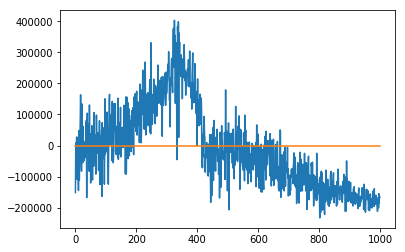

In [6]:
import time
##################################  MAIN  #########################################
if __name__ == "__main__":
    global dias_pos
    global dias_neg
    sum_rewards_total = 0
    #modelo.epsilon = 0.1
    sr=[]
    try:
        if carregar_pesos:
            modelo.carrega_pesos('./pesos.h5')
        epoca_parou = epoca_init
        for epoca in range(epoca_init, epocas): #rodar uma quantidade de epocas
            #s=time.time()
            sum_rewards = rodar_dias(inputs, custo) #adiciona o resultado da epoca na somatoria
            sum_rewards_total += sum_rewards
            sr.append(sum_rewards)
            print("resultado da epoca {0} = {1:0.2f}".format(epoca, sum_rewards))
            print(dias_pos)
            print(dias_neg)
            epoca_parou += 1
            if ((epoca % 200) == 0):
                modelo.salva_pesos('./pesos_5.h5')
            dias_pos = 0
            dias_neg = 0
            #e=time.time()
            #print(e-s)
            
            if modelo.epsilon <= epsilon_min:
                modelo.epsilon = epsilon_min
            else:
                modelo.epsilon -= epsilon_decay
    finally:
        print(dias_pos)
        print(dias_neg)
        modelo.salva_pesos('./pesos_5.h5')
        if carregar_epoca_epsilon:
            file = open("./epoca_epsilon.txt", "w")
            file.writelines("{0},{1}".format(epoca_parou, modelo.epsilon))
            file.close()
            print("parou na epoca {0} com epsilon {1}".format(epoca_parou, modelo.epsilon))
        print("Somatoria dos rewards: {0:0.2f}".format(sum_rewards_total))
        print("Melhor resultado diario: {0:0.2f}".format(melhor_reward))
        plt.plot(range(0, len(sr)), sr, range(0, len(sr)), np.zeros(len(sr))) #plota os v1alores de reward por epoca

In [7]:
print(modelo.memory)

[(-1, -0.53, array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.45302548,
        0.        , 0.        , 0.        ]]), array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.44506369,
        -0.1       ,  0.45302548, -0.00053   ]]), False), (-1, -1.06, array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.45302548,  0.44506369,
        -0.1       ,  0.45302548, -0.00053   ]]), array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.44506369,  0.44745223,
        -0.2       ,  0.44904459,  0.04894   ]]), False), (-1, -1.59, array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.45302548,  0.44506369,  0.44745223,
        -0.2       ,  0.449044

In [8]:
np.argmax(hr)

105

In [9]:
print(hr[0:106])

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105]


In [10]:
print(inputs['hr_int'])

KeyError: 'hr_int'

In [ ]:
print(hr[0:106])

In [ ]:
print(modelo.state)

In [ ]:
print(modelo.state.shape)

In [ ]:
modelo.state_size

In [ ]:
print(.shape)